In [1]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [2]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)

In [3]:
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

Cleaning the data

In [4]:
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
#We will need to replace the missing values with something. It doesnt generally matter too much what we choose. We will use the most common values . We can use the mode function  for that. One wrinkle is that it return more than one row in the case of ties, so we just grab the first row with iloc[0]:


modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [7]:
#We will fill the missing data with the mode values

df.fillna(modes, inplace=True)
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [8]:
#Here's how we get a quick summary of all the numeric columns in the dataset

import numpy as np
df.describe(include=(np.number)).columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


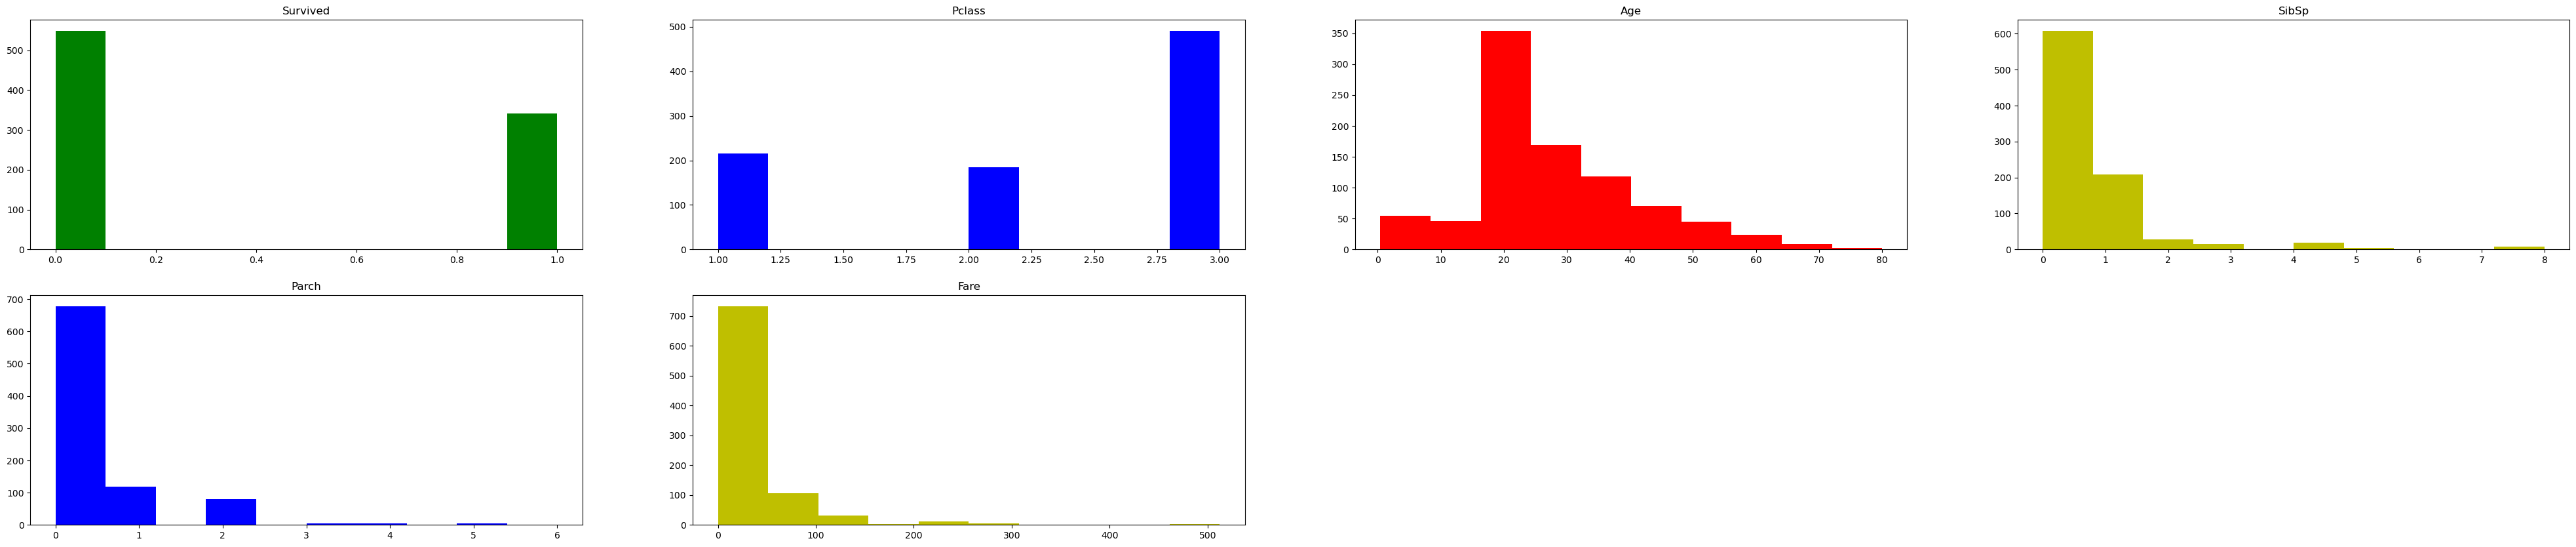

In [10]:
import enum
plt.figure(figsize=(50,10))
for i,j in enumerate(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']):
    plt.subplot(2,4,i+1)
    plt.hist(df[j],color=np.random.choice(['r','y','b','g']))
    plt.title(j)
    #plt.axis('off')

<Axes: >

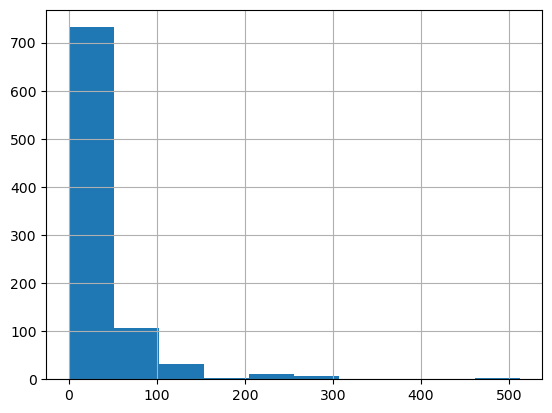

In [11]:
df['Fare'].hist()

In [12]:
#Clearly the 'Fare' Values are skewed to the left
#So we will log it and plot
df['Logfare'] = np.log(df['Fare']+1)


#There are zeroes in the column to fix this we add +1

<Axes: >

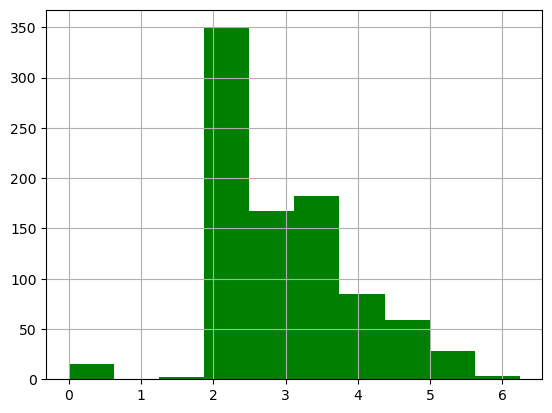

In [13]:
df['Logfare'].hist(color='g')

In [14]:
pclass = sorted(df.Pclass.unique())
pclass

[1, 2, 3]

In [15]:
#Quick summary of the non numeric components

df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [16]:
#Creating dummy variables 
df = pd.get_dummies(df, columns=['Sex', 'Pclass', "Embarked"])

In [17]:
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Logfare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [18]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,0,1,0,0,1
1,0,1,1,0,0,1,0,0
2,0,1,0,0,1,0,0,1
3,0,1,1,0,0,0,0,1
4,1,0,0,0,1,0,0,1


In [ ]:
#Create our independent predictiors and dependent target variables

from torch import tensor
t_dep = tensor(df.Survived)
t_dep